<a href="https://colab.research.google.com/github/Praymabs/Bank-Management-System/blob/main/Car_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json, numpy as np, pandas as pd, dateutil.parser
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [ ]:
def load_jsonl(path):
    rows = []
    with open(path, "r") as f:
        for line in f:
            rows.append(json.loads(line))
    return pd.DataFrame(rows)

train = load_jsonl("/content/used_cars_train.json")
test  = load_jsonl("/content/used_cars_test.json")

print("Train Shape:", train.shape)
print("Test Shape :", test.shape)

Train Shape: (71275, 17)
Test Shape : (7920, 17)


In [ ]:
print(train.head())

           id  price    year manufacturer                       model  \
0  7314977535   4000  2007.0         jeep      grand cherokee limited   
1  7314789720   4800  2006.0    chevrolet                   silverado   
2  7304863686   5500  2007.0       toyota                       yaris   
3  7311469964  26990  2016.0    chevrolet  express commercial cutaway   
4  7305988194  48995  2020.0       toyota          tundra limited 4x4   

   condition    cylinders fuel  odometer title_status transmission drive  \
0       good  8 cylinders  gas  278000.0        clean    automatic   4wd   
1       good  8 cylinders  gas  260600.0        clean    automatic   rwd   
2  excellent  4 cylinders  gas   51000.0        clean       manual   fwd   
3       good  8 cylinders  gas   75734.0        clean    automatic   rwd   
4   like new  8 cylinders  gas   20000.0         lien    automatic   4wd   

        size       type paint_color state              posting_date  
0   mid-size        SUV      silve

In [ ]:
display(train.head())

,id,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,posting_date
0,7314977535,4000,2007.0,jeep,grand cherokee limited,good,8 cylinders,gas,278000.0,clean,automatic,4wd,mid-size,SUV,silver,or,2021-04-30T12:43:00-0700
1,7314789720,4800,2006.0,chevrolet,silverado,good,8 cylinders,gas,260600.0,clean,automatic,rwd,full-size,pickup,white,fl,2021-04-30T10:31:34-0400
2,7304863686,5500,2007.0,toyota,yaris,excellent,4 cylinders,gas,51000.0,clean,manual,fwd,compact,hatchback,blue,al,2021-04-10T15:11:21-0500
3,7311469964,26990,2016.0,chevrolet,express commercial cutaway,good,8 cylinders,gas,75734.0,clean,automatic,rwd,full-size,truck,white,wi,2021-04-23T13:13:09-0500
4,7305988194,48995,2020.0,toyota,tundra limited 4x4,like new,8 cylinders,gas,20000.0,lien,automatic,4wd,full-size,truck,silver,nm,2021-04-12T20:01:35-0600


In [ ]:
def posting_year(s):
    return dateutil.parser.parse(s).year

for df in (train, test):
    df["posting_year"] = df["posting_date"].apply(posting_year)
    df["age"] = df["posting_year"] - df["year"].astype(int)

In [ ]:
ordinal_like = {"condition": ["salvage","fair","good","excellent","like new","new"]}

feature_info = []
for col in train.columns:
    dtype = str(train[col].dtype)
    nunique = train[col].nunique()
    # feature type
    if dtype.startswith(("int","float")):
        ftype = "Numerical"
    elif col in ordinal_like:
        ftype = "Ordinal/Categorical"
    else:
        ftype = "Categorical" if dtype == "object" else "Other"
    # usage
    if col == "price":
        usage = "Target"
    elif col in ["id","posting_date"]:
        usage = "Not useful"
    else:
        usage = "Useful for prediction"
    feature_info.append([col, dtype, ftype, nunique, usage])

features_df = pd.DataFrame(feature_info, columns=["Feature","Data Type","Feature Type","Unique Values","Usage"])
print("\n Feature Analysis Table:")
display(features_df.sort_values("Feature"))


 Feature Analysis Table:


,Feature,Data Type,Feature Type,Unique Values,Usage
18,age,int64,Numerical,102,Useful for prediction
5,condition,object,Ordinal/Categorical,6,Useful for prediction
6,cylinders,object,Categorical,8,Useful for prediction
11,drive,object,Categorical,3,Useful for prediction
7,fuel,object,Categorical,5,Useful for prediction
0,id,int64,Numerical,71275,Not useful
3,manufacturer,object,Categorical,41,Useful for prediction
4,model,object,Categorical,9020,Useful for prediction
8,odometer,float64,Numerical,26018,Useful for prediction
14,paint_color,object,Categorical,12,Useful for prediction


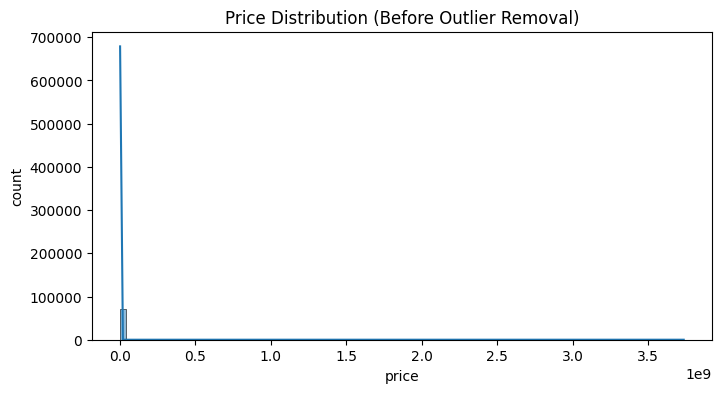

In [ ]:
#Price Distribution (Before Cleaning)
plt.figure(figsize=(8,4))
sns.histplot(train["price"], bins=100, kde=True)
plt.title("Price Distribution (Before Outlier Removal)")
plt.xlabel("price"); plt.ylabel("count")
plt.show()

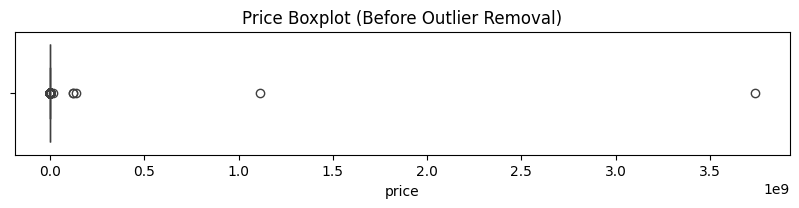

In [ ]:
plt.figure(figsize=(10,1.6))
sns.boxplot(x=train["price"], orient="h")
plt.title("Price Boxplot (Before Outlier Removal)")
plt.xlabel("price")
plt.show()

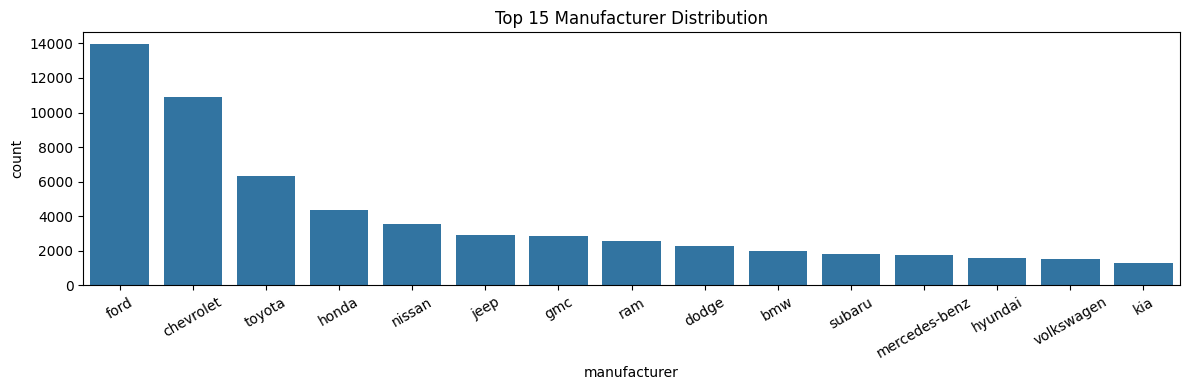

In [ ]:
#Categorical Visualization: Top 15 Manufacturers
plt.figure(figsize=(12,4))
top_manu = train["manufacturer"].value_counts().index[:15]
sns.countplot(data=train, x="manufacturer", order=top_manu)
plt.title("Top 15 Manufacturer Distribution")
plt.xticks(rotation=30)
plt.xlabel("manufacturer"); plt.ylabel("count")
plt.tight_layout(); plt.show()

In [ ]:
train_clean = train[
    (train["price"].between(500, 200000)) &
    (train["odometer"].between(500, 400000)) &
    (train["age"].between(0, 40))
].copy()

In [ ]:
categorical = ["manufacturer","condition","cylinders","fuel","title_status",
               "transmission","drive","size","type","paint_color","state"]
numeric = ["odometer"]

X_train = train_clean[numeric + categorical].copy()
y_train = train_clean["price"].astype(float)

X_test  = test[numeric + categorical].copy()
y_test  = test["price"].astype(float)

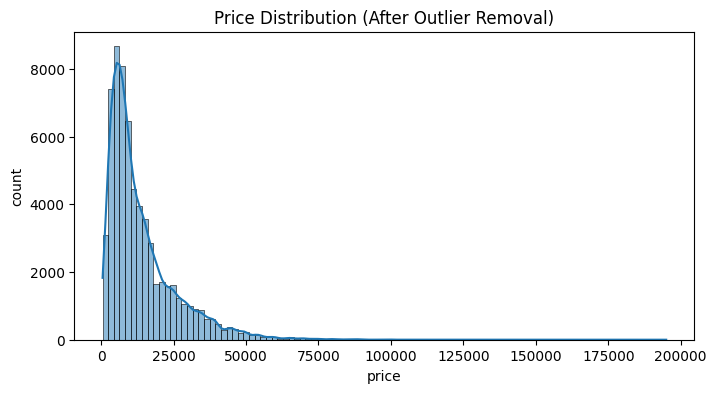

In [ ]:
#Price Distribution (After Cleaning)
plt.figure(figsize=(8,4))
sns.histplot(train_clean["price"], bins=100, kde=True)
plt.title("Price Distribution (After Outlier Removal)")
plt.xlabel("price"); plt.ylabel("count")
plt.show()

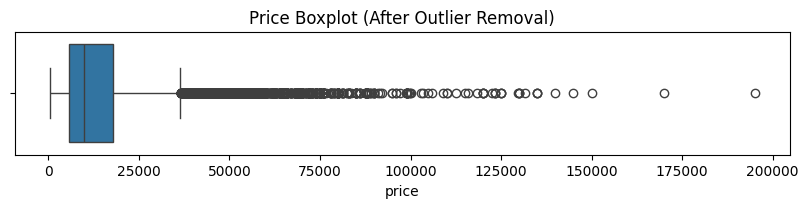

In [ ]:
# --- Outlier Visualization (Boxplot, After Cleaning) ---
plt.figure(figsize=(10,1.6))
sns.boxplot(x=train_clean["price"], orient="h")
plt.title("Price Boxplot (After Outlier Removal)")
plt.xlabel("price")
plt.show()

In [ ]:
# ---------- Preprocessing ----------
num_pipe = Pipeline(steps=[("scaler", StandardScaler())])
cat_enc = OneHotEncoder(handle_unknown="ignore")

pre = ColumnTransformer(
    transformers=[
        ("num", num_pipe, numeric),
        ("cat", cat_enc, categorical),
    ],
    remainder="drop"
)

In [ ]:
model = Pipeline(steps=[
    ("pre", pre),
    ("lr", LinearRegression())
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred = np.clip(y_pred, 0, None)

mse_lr = mean_squared_error(y_test, y_pred)
print(f"LinearRegression Test MSE: {mse_lr:,.2f}")

LinearRegression Test MSE: 87,217,188.27


In [ ]:
with open("answers.txt", "w") as f:
    f.write('{ "MSE": %.2f }' % mse_lr)
print('answers.txt written.')

answers.txt written.


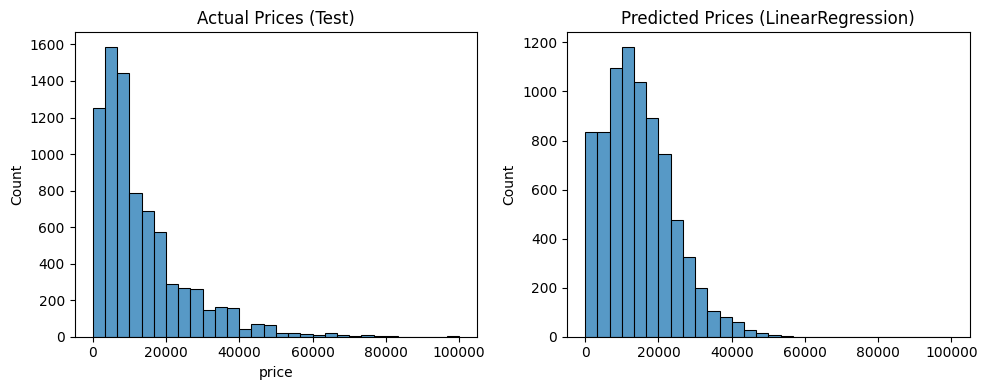

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(y_test, bins=30, binrange=(0,100000))
plt.title("Actual Prices (Test)")

plt.subplot(1,2,2)
sns.histplot(y_pred, bins=30, binrange=(0,100000))
plt.title("Predicted Prices (LinearRegression)")
plt.tight_layout(); plt.show()

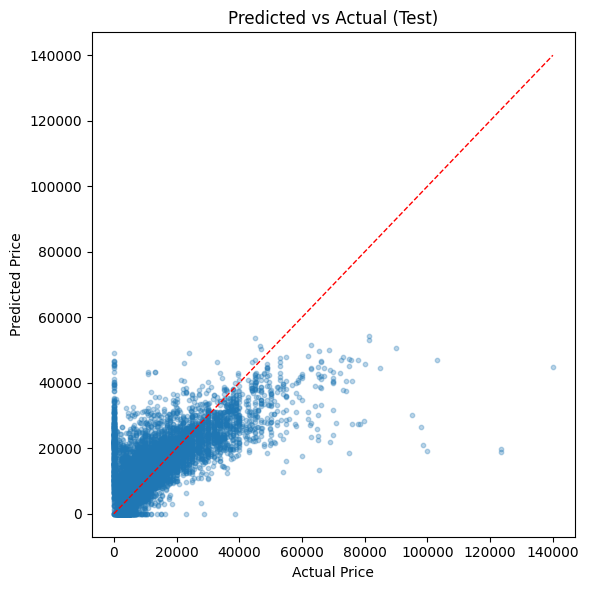

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.3, s=10)
m = max(y_test.max(), y_pred.max())
plt.plot([0,m],[0,m],'r--', linewidth=1)
plt.xlabel("Actual Price"); plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual (Test)")
plt.tight_layout(); plt.show()